# 1. Import referral letters

ToDo: remove HTML tags?

In [1]:
import pandas as pd

df_referral = pd.read_csv('../data/ZWN_verwijsbrieven.csv', sep=';')

### 1.1 Add RA label

- ToDo: Consider removing ambiguous RA patietns? (otherwise might negatively impact performance)

In [ ]:
# Get RA patients
df_RA = pd.read_csv('../dict/list_ra_patients_icd.csv', sep=';')

# OR get RA patients from stringent label
#df_RA = pd.read_csv('../dict/Demographics_RA_stringent.csv', sep=';')
l_patient = list(df_RA['Identifier'])

print('Nr of RA patients:', len(l_patient))

# Add RA diagnosis
df_referral['RA'] = df_referral['Identifier'].apply(lambda x : int(x in l_patient))

# Add time till diagnosis for RA patients 
df_extra_info = pd.read_csv('../dict/Demographics_RA_stringent.csv', sep=';')
d_diag = dict(zip(df_extra_info['Identifier'], df_extra_info['FirstDiagnosis']))

# Add time of first visit
df_agenda =pd.read_csv('../data/ZWN_afspraak.csv', sep=',')
df_first = df_agenda[df_agenda['Eerste_Afspraak']=='Ja']

d_first = dict(zip(df_first['Identifier'], df_first['Datum']))

df_referral['FirstDiagnosis'] = df_referral['Identifier'].apply(lambda x : d_diag[x] if x in d_diag.keys() else pd.NaT)
df_referral['FirstVisit'] = df_referral['Identifier'].apply(lambda x : d_first[x] if x in d_first.keys() else pd.NaT)
df_referral

In [ ]:
len(df_referral['Identifier'].unique())

### Add fibromyalgia (FMS) label

In [25]:
import pandas as pd
# get fibromyalgia patients
df_FMS = pd.read_csv('../dict/list_fms_patients_icd.csv', sep=';')
l_patient_fms = list(df_FMS['Identifier'])

# Add FMS label
df_referral['FMS'] = df_referral['Identifier'].apply(lambda x : int(x in l_patient_fms))

### Add chronic patients

In [26]:
# Get Chronic patients
df_chronic = pd.read_csv('../dict/list_chronic_pat.csv', sep=';')
l_patient_chronic = list(df_chronic['Identifier'])

# Add Chronic label
df_referral['Chronic'] = df_referral['Identifier'].apply(lambda x : int(x in l_patient_chronic))

### Add OA patients

In [27]:
# Get Chronic patients
df_oa = pd.read_csv('../dict/list_oa_patients_icd.csv', sep=';')
l_patient_oa = list(df_oa['Identifier'])

# Add Chronic label
df_referral['OA'] = df_referral['Identifier'].apply(lambda x : int(x in l_patient_oa))

### Add Arthralgia patients

In [28]:
# Get Chronic patients
df_arthralgia = pd.read_csv('../dict/list_arthralgia_patients_icd.csv', sep=';')
l_patient_arthralgia = list(df_arthralgia['Identifier'])

# Add Chronic label
df_referral['Arthralgia'] = df_referral['Identifier'].apply(lambda x : int(x in l_patient_arthralgia))

# 2. Preprocessing

In [29]:
import re 

# header footer  List  Closing  Salutation  Note Heading  Strong Emphasis  E-mail HTML Top of Form HTML Bottom of Form  No List Outline  Subtle Reference  TOC Heading Plain  Plain


def remove_html_artefacts(line):
    new_line =  line.replace('\x00', '') # remove null bytes
    new_line = re.sub(r'\\[^ ]+', r'', new_line)
    new_line = new_line.replace('}', '').replace('{', '').replace('Calibri (Vietnamese)', '').replace('envelope address;', '').replace('envelope return;', '')
    
    new_line = re.sub(r'(Kop 1|Kop 2|Kop 3|Subtle Reference|Bottom of Form|Top of Form|No List|No Spacing)', r'', new_line)
    
    # remove font names
    new_line = re.sub(r'(Default Paragraph Font|Times New Roman|Calibri|Arial|Helvetica|Cambria) [^ ]+;', r'', new_line)
    new_line = re.sub(r'(Default Paragraph Font|Times New Roman|Calibri|Arial|Helvetica|Cambria);', r'', new_line)
    new_line = re.sub(r'Cambria [^ ]+ [^ ]+;', r'', new_line)
    
    # Remove special elements
    new_line = re.sub(r'(Medium|Light|Intense|Quote|Colorful|Dark|Table|Balloon|Ballontekst|List|footnote|Normal|Grid|Closing|Body|table) .+;', r'', new_line)
    new_line = re.sub(r'(macro|toa|toc|index|footnote|line|page|endnote|annotation|heading|Heading|Block|Plain|Document|Outline|HTML) [^ ]+;', r'', new_line)
    new_line = re.sub(r'(Signature|Hyperlink|Date|caption|Normal|bottom|heading|Heading|Outline|Subtle|Form|Bottom|Emphasis|Strong|footer|header|Closing|List|Kop|Char|iText|1T3XT|Note|Salutation|Form|Top|TOC|bottom|HTML|Followed|Spacing|Plain)', r'', new_line)#new_text = re.sub(r'\\[^ ]+', r'', text)
    ## Remove caps (in case it is from html or rich text, inferring caps lock) unless it is in another word (e.g. capsule)
    new_line = re.sub(r'\b(caps)\b', r'', new_line)
    
    # Remove HEX numbers
    new_line = re.sub(r"(?<!'|-)\b[0-9a-fA-F]{4,}\b", r'', new_line)
    new_line = re.sub(' +', ' ',new_line)
    # remove all "'"
    new_line = re.sub("(?<!N)'", ' ',new_line)
    new_line = re.sub("(?<!\));", '', new_line)
    new_line = re.sub("(N'([0-9a-fA-F\-]){4,})", "\g<1>'", new_line) # add quote
    new_line = new_line.replace(" , NULL)", ", NULL)\n'").replace('Calibri', '').replace('( )', '').replace('http://schemas.microsoft.com/office/word//wordml', '')
    new_line = new_line.replace('E-mail', "")
    return new_line 

In [ ]:
### Initialize functions
import Functions as func
import time

from sklearn.feature_extraction.text import TfidfVectorizer
t = time.time()

# replace nan with empty string for preprocessing
df_referral['RTFscripted'] = df_referral['RTFscripted'].fillna('')
# remove accent
df_referral['proc_RTFscripted'] = df_referral['RTFscripted'].apply(lambda x : func.removeAccent(x))

# remove accent
df_referral['proc_RTFscripted'] = df_referral['proc_RTFscripted'].apply(lambda x : remove_html_artefacts(x))

# Maybe delete non prevalent words as well? -> with TFIDF?
print('Time to tokenize everything: {} mins'.format(round((time.time() - t) / 60, 2)))
df_referral.head()

### 2.1 Add Wordmatching algorithm label (to compare to dummy classifier)

In [ ]:
import pandas as pd
import re

def wordmatching_oa(text): 
    # No reuma -> (for fair comparison) since that might induce the number of false positives
    pattern = r'\b(' + r"|".join(['OA', 'oa', 'artrose', 'polyartrose', 'polyarthrose']) + r')\b'
    
    match = re.search(pattern, text)
    return match

def wordmatching_ra(text): 
    # No reuma -> (for fair comparison) since that might induce the number of false positives
    pattern = r'\b(' + r"|".join(['RA', 'ra', 'rheumatoid arthritis', 'reumatoide artritis', 'Ra']) + r')\b'
    
    match = re.search(pattern, text)
    return match

def wordmatching_fms(text): 
    pattern = r'\b(' + r"|".join(['fibromyalgie']) + r')\b'
    
    match = re.search(pattern, text)
    return match

def wordmatching_artralgie(text): 
    pattern = r'\b(' + r"|".join(['artralgie']) + r')\b'    
    match = re.search(pattern, text)
    return match

# Add Word matching result
df_referral['WM'] = df_referral['proc_RTFscripted'].apply(lambda x : wordmatching_ra(x))
df_referral['WM_FMS'] = df_referral['proc_RTFscripted'].apply(lambda x : wordmatching_fms(x))
df_referral['WM_OA'] = df_referral['proc_RTFscripted'].apply(lambda x : wordmatching_oa(x))
df_referral['WM_Artralgie'] = df_referral['proc_RTFscripted'].apply(lambda x : wordmatching_artralgie(x))
df_referral[['WM', 'WM_FMS', 'WM_OA', 'proc_RTFscripted']] 

### 2.2 Recognize dates?

ToDo:
- add a step that recognizes & removes names (this might also involve some bias) 

In [32]:
import numpy as np
import pandas as pd
import re 

def get_date_referral(date_text):
    """
    Sadly the dates of referral letters are not encoded -> in that case you can use this function!
    
    As a solution: we take the largest date from the text
    """
    pattern = re.compile(r'\d{2}-\d{2}-\d{4}') 
    dates = re.findall(pattern, date_text)
    if dates != []: # get date of referral
        return np.array(dates)[np.argmax([int(i.split('-')[2]) for i in dates])] #dates
    else :
        return pd.NaT
    
df_rl_date = pd.read_csv('../data/20240129_Verwijsbrief_datum.csv', sep=';')[['ID','ItemDateTime','LabelTekst']]
df_rl_date= df_rl_date.rename(columns={'ID': 'Identifier', 'ItemDateTime' : 'referral_date'})

# Apply referral letter -> acquire date
df_rl_date['Identifier'] = df_rl_date['Identifier'].apply(lambda x : x.replace('{', '').replace('}', '').lower())

df_referral = pd.merge(df_referral, df_rl_date[['Identifier', 'referral_date', 'LabelTekst']], left_on='Identifier', right_on='Identifier', how='left')
df_referral['referral_date'] = pd.to_datetime(df_referral['referral_date'], format='%d-%m-%Y', errors='coerce')
df_referral['referral_date'] = df_referral['referral_date'].fillna(df_referral['proc_RTFscripted'].apply(lambda x : pd.to_datetime(get_date_referral(x), format='%d-%m-%Y')))

df_referral['FirstVisit'] = pd.to_datetime(df_referral['FirstVisit'], format='%Y-%m-%d')

In [33]:
import re 

def get_max_date(date_text):
    pattern = re.compile(r'\d{2}-\d{2}-\d{4}') 
    return re.findall(pattern, date_text)

def replace_dates(date_text):
    pattern = re.compile(r'\d{2}-\d{2}-\d{4}') 
    return re.sub(pattern, '[DATE]', date_text)
df_referral['proc_RTFscripted'] = df_referral['proc_RTFscripted'].apply(lambda x : replace_dates(x))
#df_referral['proc_RTFscripted'] = df_referral['proc_RTFscripted'].str.lower()

### 2.3 Register whether referral letters was sent before first visit / diagnosis

In [34]:
def is_before_diagnosis(x):
    if x == x: 
        if x > 0:
            return True
        elif x <= 0: 
            return False
    return False

print('%s RA patients with referrals' % len(df_referral[df_referral['RA']==1]['Identifier'].unique()))
print('%s RA patients with referrals before diagnosis' % len(df_referral[df_referral['referral_date']<=df_referral['FirstDiagnosis']]['Identifier'].unique()))

df_referral['delta_referral_diagnosis'] = df_referral['FirstDiagnosis']- df_referral['referral_date']
df_referral['delta_referral_diagnosis'] = df_referral['delta_referral_diagnosis'].dt.days

df_referral['delta_referral_visit'] = df_referral['FirstVisit']- df_referral['referral_date']
df_referral['delta_referral_visit'] = df_referral['delta_referral_visit'].dt.days

# Also format as binary
df_referral['before_diagnosis'] = df_referral['delta_referral_diagnosis'].apply(lambda x : is_before_diagnosis(x))
df_referral['before_firstVisit'] = df_referral['delta_referral_visit'].apply(lambda x : is_before_diagnosis(x))

# Remove entries where referral date could not be identified
print('%s Patients where referral date is unclear' % len(df_referral[(df_referral['referral_date'].isna())]))

print('%s Patients in total' % len(df_referral['Identifier'].unique()))
print('%s RA patients in total ' % len(df_referral[df_referral['RA']==1]['Identifier'].unique()))
print('%s OA patients in total ' % len(df_referral[df_referral['OA']==1]['Identifier'].unique()))
print('%s FMS patients in total ' % len(df_referral[df_referral['FMS']==1]['Identifier'].unique()))
print('%s Arthralgia patients in total ' % len(df_referral[df_referral['Arthralgia']==1]['Identifier'].unique()))
print('%s Chronic patients in total ' % len(df_referral[df_referral['Chronic']==1]['Identifier'].unique()))

# Save patients with referral letter
pd.DataFrame(df_referral[df_referral['RA']==1]['Identifier'].unique()).to_csv('../dict/list_ra_patients_referral.csv', sep=';', index=None)

# Save patients with referral letter
pd.DataFrame(df_referral[df_referral['Chronic']==1]['Identifier'].unique()).to_csv('../dict/list_chronic_patients_referral.csv', sep=';', index=None)

# Save patients with referral letter
pd.DataFrame(df_referral[df_referral['OA']==1]['Identifier'].unique()).to_csv('../dict/list_oa_patients_referral.csv', sep=';', index=None)

# Save patients with referral letter
pd.DataFrame(df_referral[df_referral['Arthralgia']==1]['Identifier'].unique()).to_csv('../dict/list_arthralgia_patients_referral.csv', sep=';', index=None)

# Save dates of referral letters 
df_referral = df_referral.sort_values(by='referral_date')
# df_referral[df_referral['before_firstVisit']]
df_referral.drop_duplicates(subset=['Identifier', 'delta_referral_visit'])[['Identifier','referral_date', 'delta_referral_visit']].to_csv('../dict/df_referral_dates_new.csv', sep=';', index=None)

797 RA patients with referrals
590 RA patients with referrals before diagnosis
230 Patients where referral date is unclear
8890 Patients in total
797 RA patients in total 
1936 OA patients in total 
468 FMS patients in total 
1973 Arthralgia patients in total 
4061 Chronic patients in total 


In [18]:
len(df_referral['Identifier'].unique()), len(df_referral[df_referral['before_firstVisit']]['Identifier'].unique())

(8083, 8083)

In [66]:
df_referral.drop_duplicates(subset=['Identifier', 'delta_referral_visit'])[['Identifier','referral_date', 'delta_referral_visit']].to_csv('../dict/df_referral_dates_new.csv', sep=';', index=None)

### 2.3.2 Barplot : show number of patients with referral letter before diagnosis

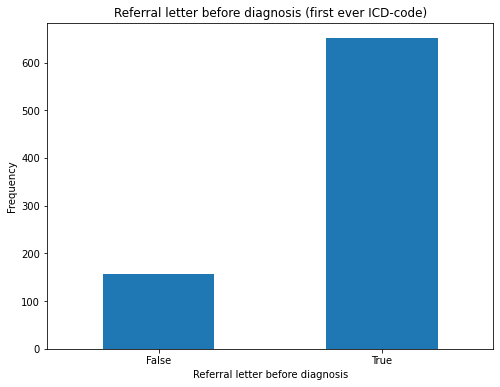

In [41]:
import matplotlib.pyplot as plt

# Count the frequency of each category
category_counts = df_referral[df_referral['RA']==1]['before_diagnosis'].value_counts()
category_counts = category_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
category_counts.plot( kind='bar')
plt.title('Referral letter before diagnosis (first ever ICD-code)')
plt.xlabel('Referral letter before diagnosis')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Remove this line if you want rotated x-axis labels
plt.show()

In [42]:
print('Referral letters where date is unclear:', len(df_referral[((df_referral['RA']==1) & (df_referral['before_diagnosis']==False) & (df_referral['referral_date'].isna()))]))

Referral letters where date is unclear: 0


### 2.4.1 Add Location information 

#### Where are the most letters coming from? 
We hold-out centers with less than 1000 letters as replication

In [ ]:
import pandas as pd
import numpy as np

thresh_loc = 1000

df_center_location = pd.read_csv('../data/20240129_Afspraak_locatie.csv', sep=';')
df_center_location['Identifier'] = df_center_location['ID'].apply(lambda x : x.replace('{', '').replace('}', '').lower())
df_center_location['GUID_Afspraak'] = df_center_location['GUID_Afspraak'].apply(lambda x : x.replace('{', '').replace('}', '').lower())
df_center_location['Datum'] = pd.to_datetime(df_center_location['Datum'], format='%Y-%m-%d')

# Add location to referral letter
d_location = dict(zip(df_center_location['Identifier'], df_center_location['Locatie']))
df_referral['Locatie'] = df_referral['Identifier'].apply(lambda x : d_location[x] if x in d_location.keys() else np.nan)
df_referral = df_referral.reset_index(drop=True)

# Use locations with less than 500 letters for replication 
category_counts = df_referral['Locatie'].value_counts()
category_counts = category_counts.sort_index()
l_validation_loc = list(category_counts[category_counts < thresh_loc].keys())
df_referral['Replication_set'] =  df_referral['Locatie'].apply(lambda x : True if x in l_validation_loc else False)

print('Centers with less than 1000 referral letters',  l_validation_loc)
print('%s out of %s referral letters have a known location' % (len(df_referral[~df_referral['Locatie'].isna()]), len(df_referral)))
print('%s out of %s referral letters have a location that frequently shares letters (min=%s)' % (len(df_referral[((~df_referral['Locatie'].isna()) & (df_referral['Replication_set']==0))]), len(df_referral[~df_referral['Locatie'].isna()]), thresh_loc))

# Export dataframe
df_referral.to_csv('../proc/ZWN_referral_proc.csv', index=False, sep='|')
df_referral.head()

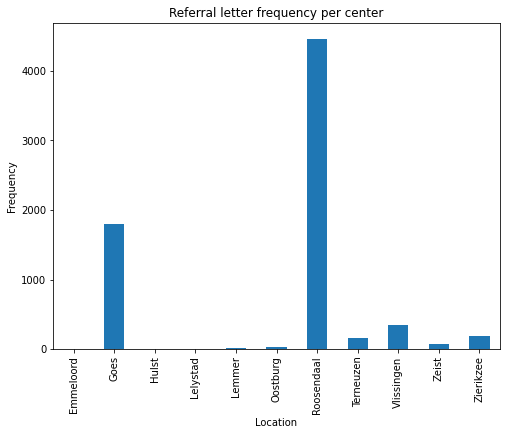

In [21]:
import matplotlib.pyplot as plt

# Count the frequency of each category
category_counts = df_referral['Locatie'].value_counts()
category_counts = category_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
category_counts.plot( kind='bar') # , color=['#4F6CCF', '#2db9cc', '#fcba03', '#FA4D4D']
plt.title('Referral letter frequency per center')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Remove this line if you want rotated x-axis labels
plt.show()

### 2.5 Employ NER (Named Entity Recognition)

Fit a MMAE Neural Network by running:
1. sbatch gitlab/referral_ml/src/EmployNER.sh
OR run as job by running referral_ml/src/2_latent_space/MMAE_job_shark.sh

#### 2.5.1 redact entities (based on confidence of 0.80)
- See notebook on NER  referral_ml/src/extra/2.5_Named_entity_recognition.ipynb for more information regarding the chosen cut-off

In [4]:
import re
import pandas as pd

df_forbidden = pd.read_csv('../proc/extra/found_entities_NER_thresh80_RK.csv', sep=';')#.values[0]
df_forbidden.columns = ['NER', 'Relevant']

l_forbidden = list(df_forbidden[df_forbidden['Relevant']!=1]['NER'])

df_referral = pd.read_csv('../proc/ZWN_referral_proc.csv', sep='|')
# Create a regex pattern to match any of the forbidden words
pattern = re.compile(r'\b(' + '|'.join(map(re.escape, l_forbidden)) + r')\b', re.IGNORECASE)

# Function to redact forbidden words
def redact_text(text):
    return pattern.sub('[REDACTED]', text)

# Apply the redaction function to the DataFrame column
df_referral['fixedLine'] = df_referral['proc_RTFscripted'].apply(redact_text)
df_referral.to_csv('../proc/ZWN_referral_blinded_NER_thresh80.csv', sep='|', index=None)

# 3. Create datasets to train model

#### We exclude both referral letters without known Location & those after first visit from the data

In [ ]:
import pandas as pd
df_referral = pd.read_csv('../proc/ZWN_referral_blinded_NER_thresh80.csv', sep='|')

print('Patients where date of referral was before first visit:', len(df_referral[df_referral['delta_referral_visit']>0]['Identifier'].unique()))

# Only select patients with known location
df_referral = df_referral[~df_referral['Locatie'].isna()]

print('Patients where Location is not missing:', len(df_referral[df_referral['before_firstVisit']==True]['Identifier'].unique()))

# Keep other centers seperate for replication
df_replication = df_referral[((df_referral['Replication_set']) & (df_referral['before_firstVisit']==True))].reset_index(drop=True).copy()

# Save replication set
df_replication.to_csv('../proc/extra/df_replication.csv', index=None)

df_referral = df_referral.reset_index(drop=True)
df_referral.head()

### 3.1 split on training & test set

In [2]:
from sklearn.model_selection import train_test_split
target = 'RA' # 'RA', 'FMS', 'Chronic'

# We make sure to stratify on target & ensure that there are no overlapping patients between validation & train
l_train, l_test = train_test_split(df_referral[df_referral['Replication_set']==False].drop_duplicates(subset=['Identifier'])[['Identifier', target]], test_size=0.2, stratify=df_referral[df_referral['Replication_set']==False].drop_duplicates(subset=['Identifier'])[['Identifier', target]][target], random_state=28072022)


# Generate train & test (whilst removing those with a first visit before )
df_train = df_referral[((df_referral['Identifier'].isin(l_train['Identifier'])) & (df_referral['before_firstVisit']==True)) ]
df_test = df_referral[((df_referral['Identifier'].isin(l_test['Identifier'])) & (df_referral['before_firstVisit']==True)) ]

# Save data splits
df_train.to_csv('../proc/extra/df_train.csv', index=None)
df_test.to_csv('../proc/extra/df_test.csv', index=None)

print('Nr of entries in trainings set:\t', len(df_train), len(df_train['Identifier'].unique()))
print('Nr of entries in test set : \t', len(df_test), len(df_test['Identifier'].unique()))

target = 'RA'

Nr of entries in trainings set:	 5039 4097
Nr of entries in test set : 	 1225 1016


In [6]:
from sklearn.model_selection import train_test_split
target = 'RA' # 'RA', 'FMS', 'Chronic'

# We make sure to stratify on target & ensure that there are no overlapping patients between validation & train
l_train, l_test = train_test_split(df_referral[df_referral['Replication_set']==False].drop_duplicates(subset=['Identifier'])[['Identifier', target]], test_size=0.2, stratify=df_referral[df_referral['Replication_set']==False].drop_duplicates(subset=['Identifier'])[['Identifier', target]][target], random_state=28072022)


# Generate train & test (whilst removing those with a first visit before )
df_train = df_referral[((df_referral['Identifier'].isin(l_train['Identifier'])) & (df_referral['before_firstVisit']==True)) ]
df_test = df_referral[((df_referral['Identifier'].isin(l_test['Identifier'])) & (df_referral['before_firstVisit']==True)) ]

# Save data splits
df_train.to_csv('../proc/extra/df_train.csv', index=None)
df_test.to_csv('../proc/extra/df_test.csv', index=None)

print('Nr of entries in trainings set:\t', len(df_train), len(df_train['Identifier'].unique()))
print('Nr of entries in test set : \t', len(df_test), len(df_test['Identifier'].unique()))

target = 'RA'

Nr of entries in trainings set:	 5017 4090
Nr of entries in test set : 	 1247 1023


### 3.2 Perform batch correction on train data

In [ ]:
from combat.pycombat import pycombat
from scipy.sparse import csr_matrix

df_train_tfidf = pd.DataFrame(X_feat.toarray(), columns=tfidf_feature_names).T
df_train_tfidf

l_batch_train = list(df_train['Locatie'])
data_corrected = df_train_tfidf.copy()
X_feat = np.array(data_corrected.T)

# Convert to CSR sparse matrix
X_feat = csr_matrix(X_feat)

### 3.3 Show prevalence of RA patients

In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of each category
category_counts = df_train['RA'].value_counts()
category_counts = category_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(6, 5))
category_counts.plot( kind='bar')
plt.title('Prevalence of RA patients ')
plt.xlabel('RA patients')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Remove this line if you want rotated x-axis labels
plt.show()

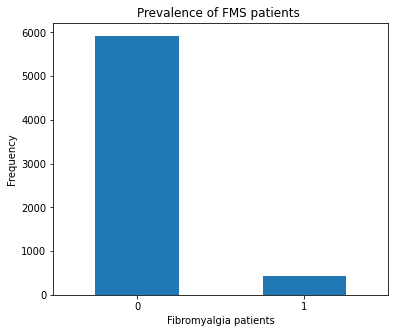

In [25]:
import matplotlib.pyplot as plt

# Count the frequency of each category
category_counts = df_train['FMS'].value_counts()
category_counts = category_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(6, 5))
category_counts.plot( kind='bar')
plt.title('Prevalence of FMS patients ')
plt.xlabel('Fibromyalgia patients')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Remove this line if you want rotated x-axis labels
plt.show()